# Personalized Medicine Predictive Modeling Workflow
Goal: Predict whether a variant is associated with a drug response or phenotype based on high-confidence clinical annotations from PharmGKB.

## Step 0: Set up the environment

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Load the TSV File
Load the PharmGKB clinical variant-drug data. (https://www.clinpgx.org/downloads) 

In [28]:
# Load the TSV file
df = pd.read_csv("clinical_variants.tsv", sep="\t")

# Quick overview
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5190 entries, 0 to 5189
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   variant            5190 non-null   object
 1   gene               4936 non-null   object
 2   type               5190 non-null   object
 3   level of evidence  5190 non-null   object
 4   chemicals          5190 non-null   object
 5   phenotypes         4176 non-null   object
dtypes: object(6)
memory usage: 243.4+ KB
None


,variant,gene,type,level of evidence,chemicals,phenotypes
0,"CYP2C9*1, CYP2C9*3, CYP2C9*13",CYP2C9,Metabolism/PK,1A,lornoxicam,NaN
1,"CYP2C9*1, CYP2C9*2, CYP2C9*3",CYP2C9,Metabolism/PK,1A,siponimod,NaN
2,rs17376848,DPYD,Toxicity,1A,capecitabine,Neoplasms
3,rs2297595,DPYD,Toxicity,1A,capecitabine,Neoplasms
4,rs1801265,DPYD,Toxicity,1A,capecitabine,Neoplasms


## Step 2: Clean the dataset

In [30]:
# Fill missing genes
df['gene'] = df['gene'].fillna('Unknown')

# Create binary target
df['phenotype_present'] = df['phenotypes'].notna().astype(int)

# Filter to focus on high-confidence variants only 
high_conf = ["1A", "1B", "2A"]
df = df[df['level of evidence'].isin(high_conf)].copy()

# Remove leading/trailing spaces in column names and string columns
df.columns = df.columns.str.strip()
string_cols = ['variant', 'gene', 'type', 'level of evidence', 'chemicals', 'phenotypes']
for col in string_cols:
    df[col] = df[col].astype(str).str.strip()

In [31]:
# Drop exact duplicates
df = df.drop_duplicates()

print("Shape after cleaning:", df.shape)

Shape after cleaning: (370, 7)


In [32]:
print("Number of unique drugs:", df['chemicals'].nunique())
print("Number of unique variants:", df['variant'].nunique())
print(df['phenotype_present'].value_counts())

Number of unique drugs: 122
Number of unique variants: 232
phenotype_present
1    289
0     81
Name: count, dtype: int64


## Step 4: Encode Variant Features
One-hot encode the variant column to create binary features for the model.

In [33]:
# One-hot encode variant names
X = pd.get_dummies(df['variant']).astype(int)
y = df['phenotype_present']

print("Feature matrix X preview:")
X.head()
print("Target vector y preview:")
y.head()

Feature matrix X preview:
Target vector y preview:


0    0
1    0
2    1
3    1
4    1
Name: phenotype_present, dtype: int64

## Step 5: Train/Test Split
Split the data into training and testing sets.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Step 6: Model 1 - Logistic Regression Model
Train a baseline classifier and evaluate performance.

In [35]:
# Initialize and train
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Evaluation
print("\n--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))


--- Logistic Regression ---
Accuracy: 0.7837837837837838
ROC AUC: 0.6691810344827586
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        16
           1       0.79      0.98      0.88        58

    accuracy                           0.78        74
   macro avg       0.65      0.52      0.49        74
weighted avg       0.73      0.78      0.71        74



## Step 7: Model 2 - Random Forest
Train a more flexible tree-based model.

In [36]:
# Initialize and train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


--- Random Forest ---
Accuracy: 0.7837837837837838
ROC AUC: 0.6449353448275862


## Step 8: Feature Importance (Random Forest)
Visualize the most predictive variants.

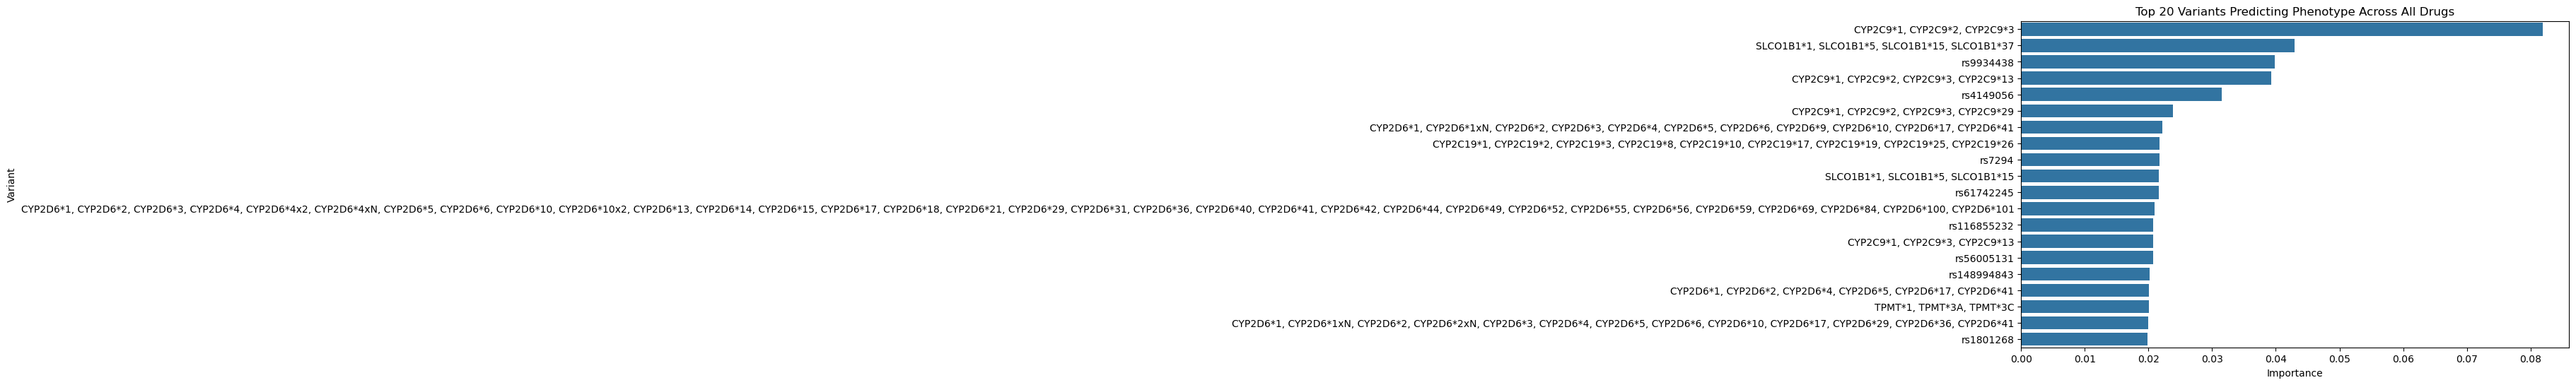

In [37]:
importance = pd.DataFrame({
    'Variant': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Variant', data=importance.head(20))
plt.title("Top 20 Variants Predicting Phenotype Across All Drugs")
plt.show()

## Step 9: Model 3 — Logistic Regression with Class Weights

In [38]:
# New Logistic Regression with balanced class weights
lr_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_balanced.fit(X_train, y_train)

# Predictions
y_pred_lr_bal = lr_balanced.predict(X_test)
y_prob_lr_bal = lr_balanced.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression (Balanced) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_bal))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr_bal))
print(classification_report(y_test, y_pred_lr_bal))


--- Logistic Regression (Balanced) ---
Accuracy: 0.7297297297297297
ROC AUC: 0.6691810344827586
              precision    recall  f1-score   support

           0       0.40      0.50      0.44        16
           1       0.85      0.79      0.82        58

    accuracy                           0.73        74
   macro avg       0.63      0.65      0.63        74
weighted avg       0.75      0.73      0.74        74



## Step 10: Model 4 — Random Forest with Class Weights

In [39]:
# New Random Forest with balanced class weights
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
rf_balanced.fit(X_train, y_train)

# Predictions
y_pred_rf_bal = rf_balanced.predict(X_test)
y_prob_rf_bal = rf_balanced.predict_proba(X_test)[:, 1]

print("\n--- Random Forest (Balanced) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_bal))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf_bal))
print(classification_report(y_test, y_pred_rf_bal))


--- Random Forest (Balanced) ---
Accuracy: 0.7567567567567568
ROC AUC: 0.6605603448275862
              precision    recall  f1-score   support

           0       0.44      0.44      0.44        16
           1       0.84      0.84      0.84        58

    accuracy                           0.76        74
   macro avg       0.64      0.64      0.64        74
weighted avg       0.76      0.76      0.76        74



## Step 11: Feature Importance (Balanced Random Forest)

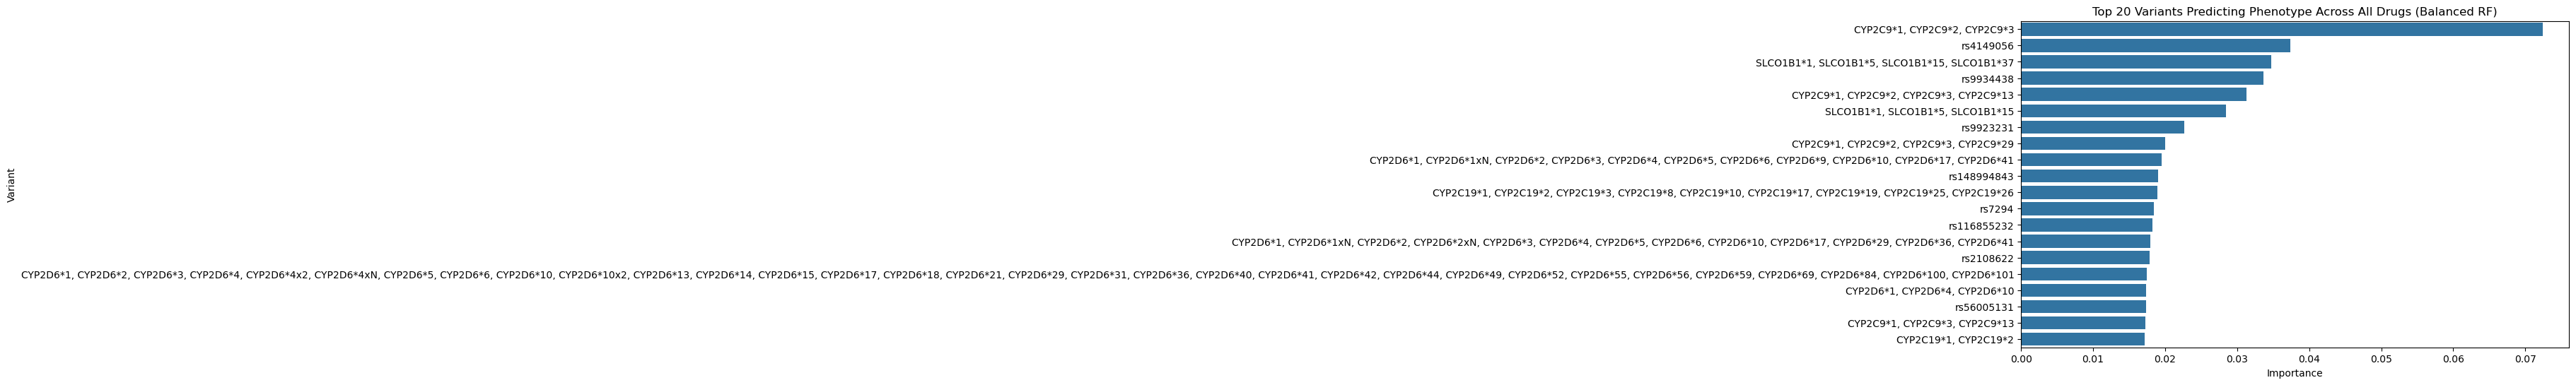

In [40]:
importance = pd.DataFrame({
    'Variant': X.columns,
    'Importance': rf_balanced.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Variant', data=importance.head(20))
plt.title("Top 20 Variants Predicting Phenotype Across All Drugs (Balanced RF)")
plt.show()